### Visual Uncertainty Comparison

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
#import tensorflow.compat.v1 as tf
import tensorflow as tf
import tensorflow_probability as tfp
import os
 
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from preprocessing.data_loader import prepare_data
import joblib
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
from tensorflow_probability import distributions as tfd

In [10]:
X_train_partial = joblib.load("./serialized/data/liver/x_train_full.lib")
y_train_partial = joblib.load("./serialized/data/liver/y_train_full.lib")
X_val = joblib.load("./serialized/data/liver/x_val_full.lib")
y_val = joblib.load("./serialized/data/liver/y_val_full.lib")
X_test = joblib.load("./serialized/data/liver/x_test_full.lib")
y_test = joblib.load("./serialized/data/liver/y_test_full.lib")

In [11]:
y_train_partial = y_train_partial.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)

In [12]:
from models.MoNet import getMoNet
from models.bayesian_MoNet import getMoNet as getBayesMoNet

determ_monet = getMoNet(input_shape=(256, 256, 1), output_classes=1, output_activation=None)
determ_monet.load_weights("./serialized/weights/deterministic_monet_liver.h5")

In [13]:
model = getMoNet(input_shape=(256, 256, 1), output_classes=1, output_activation=None)
bernoulli_monet = tf.keras.Sequential([
    model,
    tfp.layers.DistributionLambda(
      lambda t: tfp.distributions.Bernoulli(logits=t)),
])
bernoulli_monet.load_weights("./serialized/weights/bern_monet_liver.h5")

In [14]:
backbone_model = getBayesMoNet(input_shape=(256, 256, 1), output_classes=1, output_activation='sigmoid', num_train_examples=X_train_partial.shape[0])
fullGas_monet = tf.keras.Sequential([
    backbone_model,
    tfp.layers.DistributionLambda(
      lambda t: tfp.distributions.Bernoulli(logits=t)),
])
fullGas_monet.load_weights("./serialized/weights/full_bayesianMoNet_liver.h5")

In [15]:
flipout_model = getBayesMoNet(input_shape=(256, 256, 1), output_classes=1, output_activation='sigmoid', num_train_examples=X_train_partial.shape[0])
flipout_model.load_weights("./serialized/weights/flipout_MoNet_liver.h5")

... predicting on img: 1646


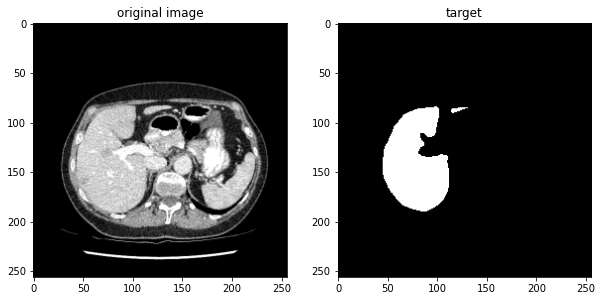

determistic model


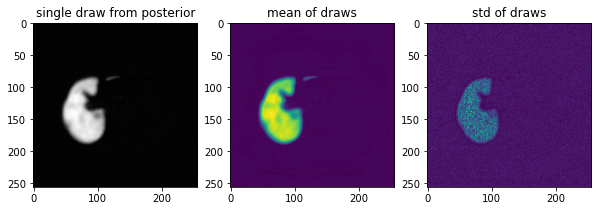

bernoulli model


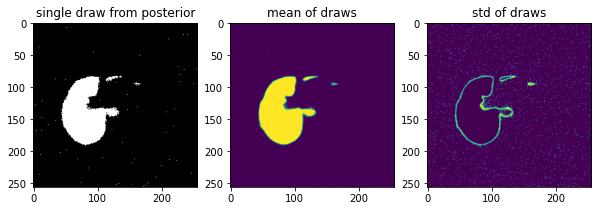

flipout model


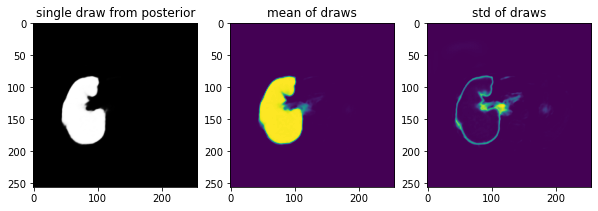

... predicting on img: 119


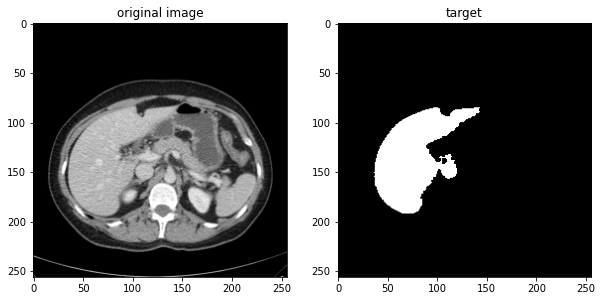

determistic model


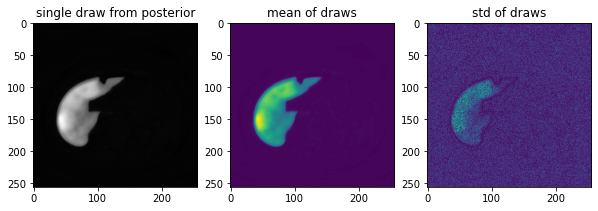

bernoulli model


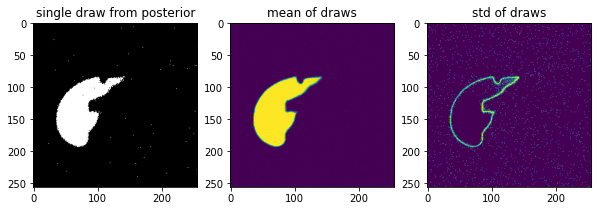

flipout model


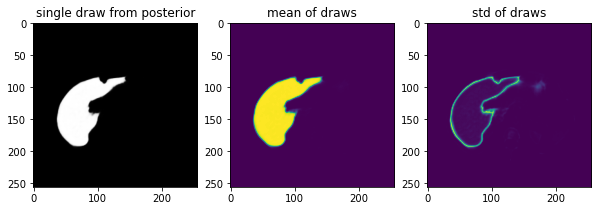

... predicting on img: 973


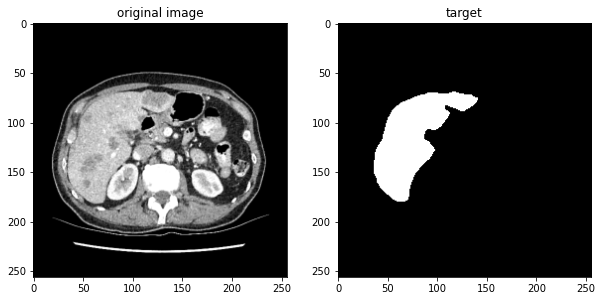

determistic model


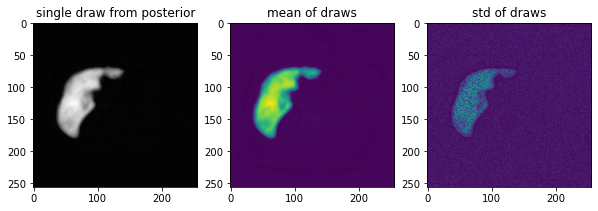

bernoulli model


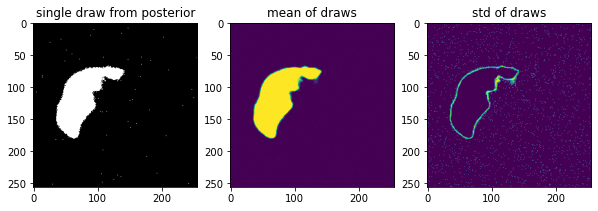

flipout model


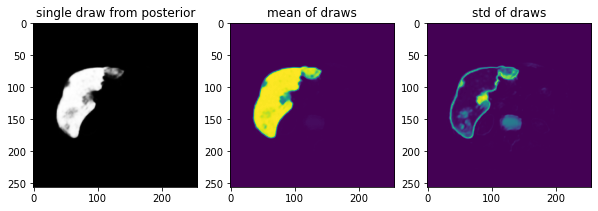

In [17]:
n_draws = 30
n_samples = 3

for _ in range(n_samples):
    ind = np.random.randint(0, X_test.shape[0])
    img = X_test[None, ind]
    print(f"... predicting on img: {ind}")
    fig, ax = plt.subplots(1, 2, figsize=(10, 20))
    ax[0].imshow(img[0], cmap='gray')
    ax[0].set_title("original image")
    ax[1].imshow(y_test[ind].squeeze(), cmap='gray')
    ax[1].set_title("target")
    plt.show()
    model_names = ["determistic model", "bernoulli model", "flipout model"]
    for i, m in enumerate([determ_monet, bernoulli_monet, flipout_model]):
        print(model_names[i])
        y_pred = [m.predict(img) for _ in range(n_draws)]
        y_pred = np.stack(y_pred)
        fig, axes = plt.subplots(1, 3, figsize=(10, 20))
        axes[0].imshow(y_pred[0].squeeze(), cmap='gray')
        axes[0].set_title("single draw from posterior")
        axes[1].imshow(np.mean(y_pred.squeeze(), axis=0))
        axes[1].set_title("mean of draws")
        axes[2].imshow(np.std(y_pred.squeeze(), axis=0))
        axes[2].set_title("std of draws")
        plt.show()    